In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [2]:
dataset = pd.read_csv('../../datasets/sp_500_stocks/sp500_index.csv')

In [3]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

,Date,S&P500
0,2014-12-01,2053.44
1,2014-12-02,2066.55
2,2014-12-03,2074.33
3,2014-12-04,2071.92
4,2014-12-05,2075.37
...,...,...
2512,2024-11-22,5969.34
2513,2024-11-25,5987.37
2514,2024-11-26,6021.63
2515,2024-11-27,5998.74


In [4]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
dataset['average_price'] = dataset["S&P500"]
dataset = dataset.drop(columns=["S&P500"])
dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
dataset['quarter'] = dataset['Date'].dt.quarter
def get_season(month):
    if month in [12, 1, 2]:
        return 0#'winter'
    elif month in [3, 4, 5]:
        return 1#'spring'
    elif month in [6, 7, 8]:
        return 2#'summer'
    else:
        return 3#'autumn'
dataset['season'] = dataset['Month'].apply(get_season)
dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


days_ago = 30

#dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
#dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
#dataset["price_365_days_ago"] = dataset["average_price"].shift(365)

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber"] #, "price_30_days_ago", "price_180_days_ago", "price_365_days_ago"]
fieldsPrice = ["average_price"]


dataset = dataset.dropna().reset_index(drop=True)

dataset

,Date,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber
0,2014-12-01,735568,2053.44,0,12,2014,335,49,1,0,4,0,1
1,2014-12-02,735569,2066.55,1,12,2014,336,49,0,0,4,0,2
2,2014-12-03,735570,2074.33,2,12,2014,337,49,0,0,4,0,3
3,2014-12-04,735571,2071.92,3,12,2014,338,49,0,0,4,0,4
4,2014-12-05,735572,2075.37,4,12,2014,339,49,0,0,4,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2024-11-22,739212,5969.34,4,11,2024,327,47,0,0,4,3,3645
2513,2024-11-25,739215,5987.37,0,11,2024,330,48,0,0,4,3,3648
2514,2024-11-26,739216,6021.63,1,11,2024,331,48,0,0,4,3,3649
2515,2024-11-27,739217,5998.74,2,11,2024,332,48,0,0,4,3,3650


In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [6]:
from datetime import datetime

def generateRandomDate():
    max_date = pd.to_datetime(dataset['Date'].max())
    max_valid_date = max_date - pd.DateOffset(years=3)
    min_valid_date = pd.to_datetime(dataset['Date'].min())

    delta = (max_valid_date - min_valid_date).days
    random_days = np.random.randint(0, delta + 1)
    random_date0 = min_valid_date + pd.Timedelta(days=random_days)
    return random_date0

random_date = datetime.strptime("30/3/2020", "%d/%m/%Y") #generateRandomDate()

In [7]:
filtered_df = dataset[(dataset['Date'] >= random_date)]

In [8]:
testRanges = [1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361]
train_days = 365
nJobs = 5
nEstimators = 100
block_size = 20

In [34]:
def getTrainTest(filtered_df0, pivote_date0, head=29):
    max_train_day = pivote_date0 + pd.DateOffset(years=1)
    blockDf = filtered_df0[(filtered_df0['Date'] >= pivote_date0) & (filtered_df0['Date'] <= max_train_day)]
    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X_train0 = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_train0 = aux.copy()
    
    #Se toman los siguientes 29 días hábiles
    blockDf = filtered_df0[filtered_df0["Date"] > max_train_day].head(head)
    #filtered_df0[(filtered_df0['Date'] > max_train_day) & (filtered_df0['Date'] <= max_test_day)]
    
    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X_test0 = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_test0 = aux.copy()

    return X_train0, Y_train0, X_test0, Y_test0

In [10]:
basicRFPrecision = dict()
precisionNonOverlapping = dict()
precisionMovingBlock = dict()
precisionCircularBlock = dict()

resultBasicRF = dict()
resultNonOverlapping = dict()
resultMovingBlock = dict()
resultCircularBlock = dict()

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

pivote_date = random_date
for testRange in testRanges:
    X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, pivote_date)
    basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    basicRFPrecision[testRange] = rmse0
    resultBasicRF[testRange] = (Y_test["average_price"].values[0], y_pred[0])

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionNonOverlapping[testRange] = rmse0
    resultNonOverlapping[testRange] = (Y_test["average_price"].values[0], y_pred[0])

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionMovingBlock[testRange] = rmse0
    resultMovingBlock[testRange] = (Y_test["average_price"].values[0], y_pred[0])

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionCircularBlock[testRange] = rmse0
    resultCircularBlock[testRange] = (Y_test["average_price"].values[0], y_pred[0])
    
    pivote_date = random_date + pd.DateOffset(days=testRange)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

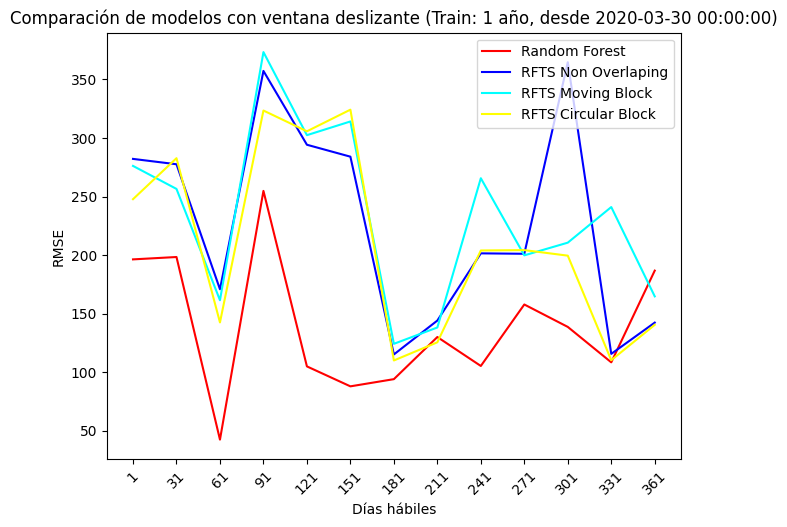

In [12]:
labels = list(basicRFPrecision.keys())
all_arr0 = list(basicRFPrecision.values())
all_arr = list(precisionNonOverlapping.values())
all_arr1 = list(precisionMovingBlock.values())
all_arr2 = list(precisionCircularBlock.values())


bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    
plt.legend()

plt.xticks(range(0, len(labels)), labels)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("RMSE")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=45)

plt.show()

In [13]:
expectedValuesRf = []
predictedValuesRf = []
predictedValuesRftsNO = []
predictedValuesRftsMB = []
predictedValuesRftsCB = []

for kTestRange in resultBasicRF:
    expectedValuesRf.append(resultBasicRF[kTestRange][0])
    predictedValuesRf.append(resultBasicRF[kTestRange][1])
for kTestRange in resultBasicRF:
    predictedValuesRftsNO.append(resultNonOverlapping[kTestRange][1])
for kTestRange in resultBasicRF:
    predictedValuesRftsMB.append(resultMovingBlock[kTestRange][1])
for kTestRange in resultBasicRF:
    predictedValuesRftsCB.append(resultCircularBlock[kTestRange][1])

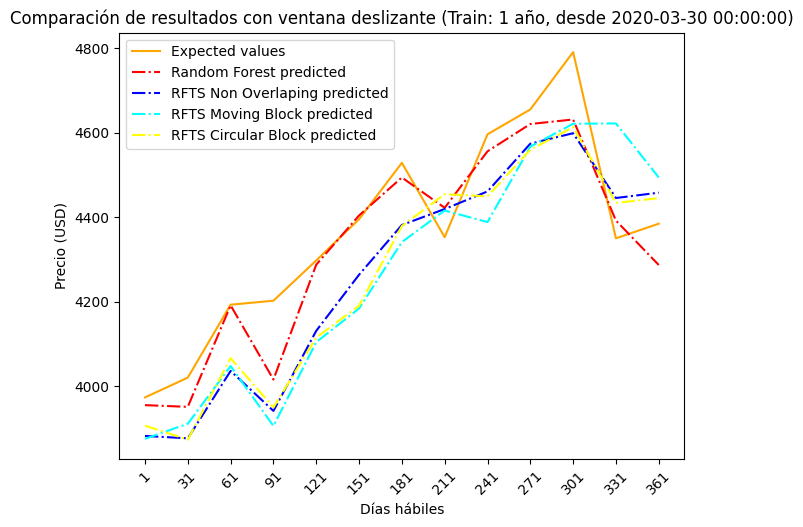

In [14]:
bp = plt.plot(expectedValuesRf, color='orange', label="Expected values", linestyle='-')
bp0 = plt.plot(predictedValuesRf, color='red', label="Random Forest predicted", linestyle='-.')
bp1 = plt.plot(predictedValuesRftsNO, color='blue', label="RFTS Non Overlaping predicted", linestyle='-.')
bp2 = plt.plot(predictedValuesRftsMB, color='cyan', label="RFTS Moving Block predicted", linestyle='-.')
bp3 = plt.plot(predictedValuesRftsCB, color='yellow', label="RFTS Circular Block predicted", linestyle='-.')


plt.legend()

plt.xticks(range(0, len(labels)), labels)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("Precio (USD)")
plt.title(f"Comparación de resultados con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=45)

plt.show()

In [15]:
basicRFPrecision2 = dict()
precisionNonOverlapping2 = dict()
precisionMovingBlock2 = dict()
precisionCircularBlock2 = dict()
for testRange in testRanges:
    basicRFPrecision2[testRange] = []
    precisionNonOverlapping2[testRange] = []
    precisionMovingBlock2[testRange] = []
    precisionCircularBlock2[testRange] = []

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

random_date2 = generateRandomDate()
filtered_df0 = dataset[(dataset['Date'] >= random_date2)]
for i in range(50):
    pivote_date = random_date2
    for testRange in testRanges:
        X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df0, pivote_date)
        basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
        basicRF.fit(X_train, Y_train)
        y_pred = basicRF.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        basicRFPrecision2[testRange].append(rmse0)

        rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionNonOverlapping2[testRange].append(rmse0)

        rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionMovingBlock2[testRange].append(rmse0)

        rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionCircularBlock2[testRange].append(rmse0)
        
        pivote_date = random_date2 + pd.DateOffset(days=testRange)
    random_date2 = generateRandomDate()
    filtered_df0 = dataset[(dataset['Date'] >= random_date2)]

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

In [17]:
for testRange in testRanges:
    basicRFPrecision2[testRange] = sum(basicRFPrecision2[testRange]) / len(basicRFPrecision2[testRange])
    precisionNonOverlapping2[testRange] = sum(precisionNonOverlapping2[testRange]) / len(precisionNonOverlapping2[testRange])
    precisionMovingBlock2[testRange] = sum(precisionMovingBlock2[testRange]) / len(precisionMovingBlock2[testRange])
    precisionCircularBlock2[testRange] = sum(precisionCircularBlock2[testRange]) / len(precisionCircularBlock2[testRange])

In [18]:
basicRFPrecision2

{1: 137.85340534130782,
 31: 132.64713326378944,
 61: 117.16923167414869,
 91: 133.64750649940956,
 121: 143.48723278261025,
 151: 142.7827988501698,
 181: 149.10764793499905,
 211: 145.337903346699,
 241: 131.57964373319237,
 271: 121.23370681922026,
 301: 128.07116814457598,
 331: 120.31348571684184,
 361: 115.67551438371927}

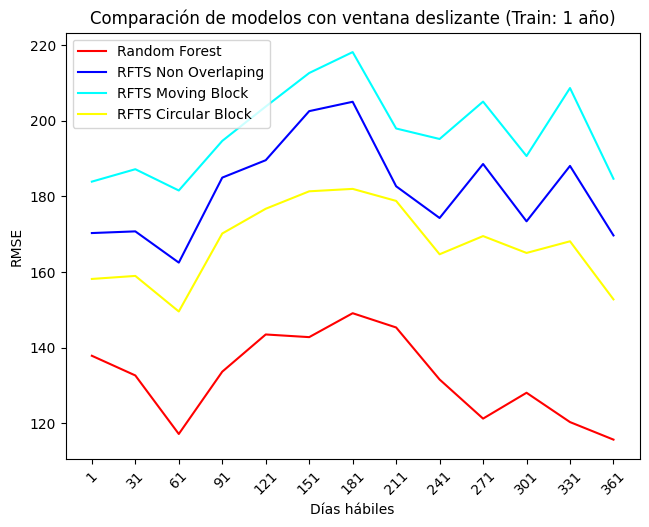

In [19]:
labels = list(basicRFPrecision.keys())
all_arr0 = list(basicRFPrecision2.values())
all_arr = list(precisionNonOverlapping2.values())
all_arr1 = list(precisionMovingBlock2.values())
all_arr2 = list(precisionCircularBlock2.values())


bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    
plt.legend()

plt.xticks(range(0, len(labels)), labels)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("RMSE")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año)")
plt.xticks(rotation=45)

plt.show()

In [20]:
basicRFPrecision = dict()
precisionNonOverlapping = dict()
precisionMovingBlock = dict()
precisionCircularBlock = dict()

In [21]:
pivote_date = random_date
for testRange in testRanges[:5]:
    X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, pivote_date)
    basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    basicRFPrecision[testRange] = rmse0
    X_test0 = X_test.tail(22)
    Y_test0 = Y_test.tail(22)
    y_pred = basicRF.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    basicRFPrecision[testRange + 7] = rmse0
    X_test1 = X_test.tail(15)
    Y_test1 = Y_test.tail(15)
    y_pred = basicRF.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    basicRFPrecision[testRange + 14] = rmse0
    X_test2 = X_test.tail(8)
    Y_test2 = Y_test.tail(8)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    basicRFPrecision[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionNonOverlapping[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionNonOverlapping[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionNonOverlapping[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionNonOverlapping[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionMovingBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionMovingBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionMovingBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionMovingBlock[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionCircularBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionCircularBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionCircularBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionCircularBlock[testRange + 21] = rmse0
    
    pivote_date = random_date + pd.DateOffset(days=testRange)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

In [22]:
ticks001 = []
for testRange in testRanges[:5]:
    ticks001.append(str(testRange))
    ticks001.append(str(testRange + 7))
    ticks001.append(str(testRange + 14))
    ticks001.append(str(testRange + 21))

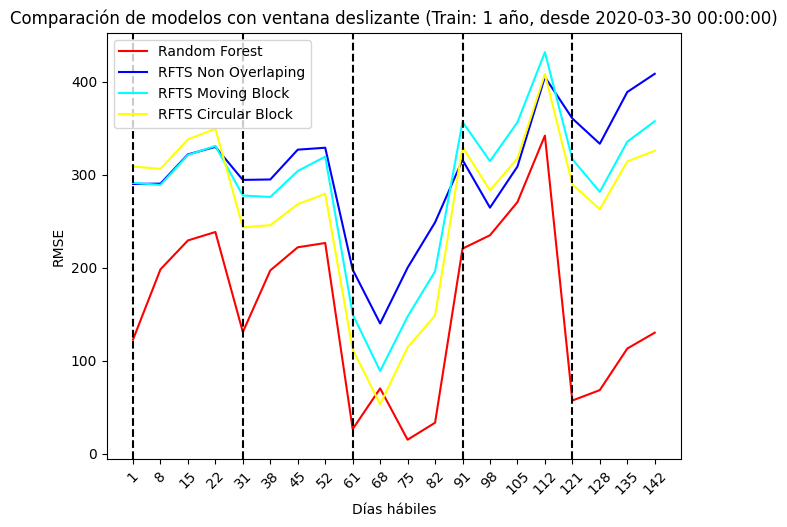

In [23]:
all_arr0 = list(basicRFPrecision.values())
all_arr = list(precisionNonOverlapping.values())
all_arr1 = list(precisionMovingBlock.values())
all_arr2 = list(precisionCircularBlock.values())


bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    
plt.legend()

plt.xticks(range(0, len(ticks001)), ticks001)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("RMSE")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=45)

i = 0
for testRange in testRanges[:5]:
    plt.axvline(x=i * 4, color='black', linestyle='--')
    i+=1

plt.show()

In [37]:
testRanges2 = [1, 61, 121, 181, 241, 301]

In [48]:
basicRFPrecision = dict()
precisionNonOverlapping = dict()
precisionMovingBlock = dict()
precisionCircularBlock = dict()

In [49]:
pivote_date = random_date
for testRange in testRanges2:
    X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, pivote_date, 59)
    basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    basicRFPrecision[testRange] = rmse0
    X_test0 = X_test.tail(52)
    Y_test0 = Y_test.tail(52)
    y_pred = basicRF.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    basicRFPrecision[testRange + 7] = rmse0
    X_test1 = X_test.tail(45)
    Y_test1 = Y_test.tail(45)
    y_pred = basicRF.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    basicRFPrecision[testRange + 14] = rmse0
    X_test2 = X_test.tail(38)
    Y_test2 = Y_test.tail(38)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    basicRFPrecision[testRange + 21] = rmse0
    X_test3 = X_test.tail(31)
    Y_test3 = Y_test.tail(31)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test3.head(7), y_pred))
    basicRFPrecision[testRange + 28] = rmse0
    X_test4 = X_test.tail(24)
    Y_test4 = Y_test.tail(24)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test4.head(7), y_pred))
    basicRFPrecision[testRange + 35] = rmse0
    X_test5 = X_test.tail(17)
    Y_test5 = Y_test.tail(17)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test5.head(7), y_pred))
    basicRFPrecision[testRange + 42] = rmse0
    X_test6 = X_test.tail(10)
    Y_test6 = Y_test.tail(10)
    y_pred = basicRF.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test6.head(7), y_pred))
    basicRFPrecision[testRange + 49] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionNonOverlapping[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionNonOverlapping[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionNonOverlapping[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionNonOverlapping[testRange + 21] = rmse0
    y_pred = rfts.predict(X_test3.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test3.head(7), y_pred))
    precisionNonOverlapping[testRange + 28] = rmse0
    y_pred = rfts.predict(X_test4.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test4.head(7), y_pred))
    precisionNonOverlapping[testRange + 35] = rmse0
    y_pred = rfts.predict(X_test5.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test5.head(7), y_pred))
    precisionNonOverlapping[testRange + 42] = rmse0
    y_pred = rfts.predict(X_test6.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test6.head(7), y_pred))
    precisionNonOverlapping[testRange + 49] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionMovingBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionMovingBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionMovingBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionMovingBlock[testRange + 21] = rmse0
    y_pred = rfts.predict(X_test3.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test3.head(7), y_pred))
    precisionMovingBlock[testRange + 28] = rmse0
    y_pred = rfts.predict(X_test4.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test4.head(7), y_pred))
    precisionMovingBlock[testRange + 35] = rmse0
    y_pred = rfts.predict(X_test5.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test5.head(7), y_pred))
    precisionMovingBlock[testRange + 42] = rmse0
    y_pred = rfts.predict(X_test6.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test6.head(7), y_pred))
    precisionMovingBlock[testRange + 49] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionCircularBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionCircularBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionCircularBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionCircularBlock[testRange + 21] = rmse0
    y_pred = rfts.predict(X_test3.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test3.head(7), y_pred))
    precisionCircularBlock[testRange + 28] = rmse0
    y_pred = rfts.predict(X_test4.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test4.head(7), y_pred))
    precisionCircularBlock[testRange + 35] = rmse0
    y_pred = rfts.predict(X_test5.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test5.head(7), y_pred))
    precisionCircularBlock[testRange + 42] = rmse0
    y_pred = rfts.predict(X_test6.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test6.head(7), y_pred))
    precisionCircularBlock[testRange + 49] = rmse0
    
    pivote_date = random_date + pd.DateOffset(days=testRange)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

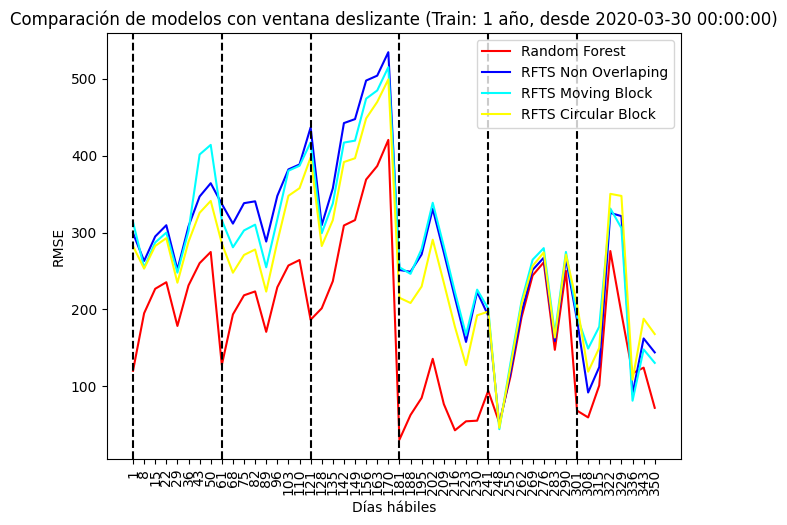

In [50]:
ticks002 = []
for testRange in testRanges2:
    ticks002.append(str(testRange))
    ticks002.append(str(testRange + 7))
    ticks002.append(str(testRange + 14))
    ticks002.append(str(testRange + 21))
    ticks002.append(str(testRange + 28))
    ticks002.append(str(testRange + 35))
    ticks002.append(str(testRange + 42))
    ticks002.append(str(testRange + 49))

all_arr0 = list(basicRFPrecision.values())
all_arr = list(precisionNonOverlapping.values())
all_arr1 = list(precisionMovingBlock.values())
all_arr2 = list(precisionCircularBlock.values())


bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    
plt.legend()

plt.xticks(range(0, len(ticks002)), ticks002)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("RMSE")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=90)

i = 0
for testRange in testRanges2:
    plt.axvline(x=i * 8, color='black', linestyle='--')
    i+=1

plt.show()